# MORDM

Many Objectives Decision Making

MORDM has four main steps:

(i) problem formulation based on a systems analytical problem definition framework

(ii) searching for candidate solutions that optimize multiple objectives by using multi-objective evolutionary algorithms

(iii) generating an ensemble of scenarios to explore the effects of uncertainties

(iv) using scenario discovery to detect the vulnerabilities of candidate solutions and improving thecandidate solutions

In [35]:
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    perform_experiments,
    Samplers,
    Scenario,
    ScalarOutcome
)
import numpy as np
import pandas as pd
import copy
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time, min_over, guaranteed95_over, guaranteed98_over

from ema_workbench.em_framework.optimization import EpsilonProgress

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Select problem formulation 3 - Water Levels
ema_logging.log_to_stderr(ema_logging.INFO)
dike_model, planning_steps = get_model_for_problem_formulation(3)

## Problem Formulation


The room for the river model has 6 outcome indicators. The first four indicators are specific to each dike and the last two concern the model as a whole:
- Expected Annual Damage
- Expected Number of Deaths
- Dike Investment Costs
- Water Level
- RfR Total Costs
- Expected Evacuation Costs

As analysts for the transport company, the capacity to transport goods in the river is heavily dependent on the water level staying above a threshold. Therefore, it is crucial for the problem owner to focus on the policies where this target is met. Nonetheless, based on the insights provided by the different stakeholders during the debate, it becomes imperative to explore options that have the desired water level with the least amount of casualties and costs.

In [4]:
# Model Uncertainties
for uncertainty in dike_model.uncertainties:
    print(repr(uncertainty))

uncertainties = copy.deepcopy(dike_model.uncertainties)

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132, resolution=None, default=None, variable_name=['A.0_ID flood wave shape'], pff=False)
RealParameter('A.1_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.1_Bmax'], pff=False)
RealParameter('A.1_pfail', 0, 1, resolution=None, default=None, variable_name=['A.1_pfail'], pff=False)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.2_Bmax'], pff=False)
RealParameter('A.2_pfail', 0, 1, resolution=None, default=None, variable_name=['A.2_pfail'], pff=False)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.3_Bmax'], pff=False)
RealParameter('A.3_pfail', 0, 1, resolution=None, default=None, variable_name=['A.3_pfai

In [5]:
# Policy Levers
for policy in dike_model.levers:
    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)

IntegerParameter('0_RfR 0', 0, 1, resolution=None, default=None, variable_name=['0_RfR 0'], pff=False)
IntegerParameter('0_RfR 1', 0, 1, resolution=None, default=None, variable_name=['0_RfR 1'], pff=False)
IntegerParameter('0_RfR 2', 0, 1, resolution=None, default=None, variable_name=['0_RfR 2'], pff=False)
IntegerParameter('1_RfR 0', 0, 1, resolution=None, default=None, variable_name=['1_RfR 0'], pff=False)
IntegerParameter('1_RfR 1', 0, 1, resolution=None, default=None, variable_name=['1_RfR 1'], pff=False)
IntegerParameter('1_RfR 2', 0, 1, resolution=None, default=None, variable_name=['1_RfR 2'], pff=False)
IntegerParameter('2_RfR 0', 0, 1, resolution=None, default=None, variable_name=['2_RfR 0'], pff=False)
IntegerParameter('2_RfR 1', 0, 1, resolution=None, default=None, variable_name=['2_RfR 1'], pff=False)
IntegerParameter('2_RfR 2', 0, 1, resolution=None, default=None, variable_name=['2_RfR 2'], pff=False)
IntegerParameter('3_RfR 0', 0, 1, resolution=None, default=None, variable

In [6]:
# Model Outcomes
for outcome in dike_model.outcomes:
    print(repr(outcome))

ScalarOutcome('A.1 Total Costs', variable_name=('A.1_Expected Annual Damage', 'A.1_Dike Investment Costs'), function=<function sum_over at 0x0000022237D3E520>)
ScalarOutcome('A.1_Expected Number of Deaths', variable_name=('A.1_Expected Number of Deaths',), function=<function sum_over at 0x0000022237D3E520>)
ScalarOutcome('A.1_Minimum Water Level', variable_name=('A.1_Water Level',), function=<function min_over at 0x000002223863A840>)
ScalarOutcome('A.1_95% Guaranteed Water Level', variable_name=('A.1_Water Level',), function=<function guaranteed95_over at 0x0000022238664B80>)
ScalarOutcome('A.1_98% Guaranteed Water Level', variable_name=('A.1_Water Level',), function=<function guaranteed98_over at 0x0000022238664C20>)
ScalarOutcome('A.2 Total Costs', variable_name=('A.2_Expected Annual Damage', 'A.2_Dike Investment Costs'), function=<function sum_over at 0x0000022237D3E520>)
ScalarOutcome('A.2_Expected Number of Deaths', variable_name=('A.2_Expected Number of Deaths',), function=<funct

## Candidate Strategies
There are three ways in which we can use optimization in the workbench:

### Option 1: Search over levers
Direct search is used to go through the decision levers to find good candidate strategies that meet the desired outcomes of the problem owner.

In [24]:
# Define a reference scenario. (EXAMPLE SCENARIO) Change for PRIM results (ONLY STATISTICAL SIGNIFICANT VALUES)

reference_scenario = Scenario('reference', **{'discount rate 0': 2.5,
                                              'discount rate 1': 2.5,
                                              'discount rate 2': 2.5,
                                              'A.0_ID flood wave shape': 75,
                                              'A.1_Bmax': 190, 'A.1_pfail': (0.2 - 0.0005)/2, 'A.1_Brate': 1.5,
                                              'A.2_Bmax': 190, 'A.2_pfail': 0.5, 'A.2_Brate': 1.5,
                                              'A.3_Bmax': 190, 'A.3_pfail': 0.5, 'A.3_Brate': 1.5,
                                              'A.4_Bmax': 190, 'A.4_pfail': 0.5, 'A.4_Brate': 1.5,
                                              'A.5_Bmax': 190, 'A.5_pfail': 0.5, 'A.5_Brate': 1.5})

In [29]:
# Define metrics for the optimization
convergence_metrics = [EpsilonProgress()]
epsilon = [0.05] * len(dike_model.outcomes)
nfe = 1000  # proof of principle only, way to low for actual use

with MultiprocessingEvaluator(dike_model) as evaluator:
    results, convergence = evaluator.optimize(
        nfe=nfe,
        searchover="levers",
        epsilons=epsilon,
        convergence=convergence_metrics,
        reference=reference_scenario,
        )

[MainProcess/INFO] pool started with 12 workers
100%|██████████████████████████████████████| 1000/1000 [01:35<00:00, 10.42it/s]
[MainProcess/INFO] optimization completed, found 390 solutions
[MainProcess/INFO] terminating pool


In [30]:
results
results.to_excel('MORDM_.xlsx')

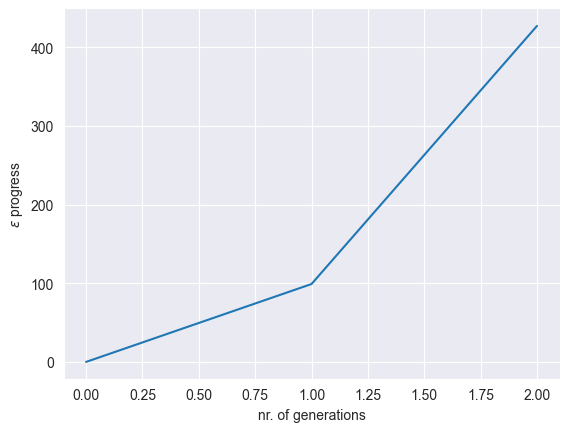

In [32]:
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True)
fig, ax1 = plt.subplots(ncols=1)
ax1.plot(convergence.epsilon_progress)
ax1.set_xlabel("nr. of generations")
ax1.set_ylabel(r"$\epsilon$ progress")
sns.despine()

### Option 2: Search over uncertainties

In [21]:

# Define a reference scenario (This scenario came by default on the model). Change for PRIM results (ONLY STATISTICAL SIGNIFICANT VALUES)
reference_values = {
    "Bmax": 175,
    "Brate": 1.5,
    "pfail": 0.5,
    "discount rate 0": 3.5,
    "discount rate 1": 3.5,
    "discount rate 2": 3.5,
    "ID flood wave shape": 4,
}
scen1 = {}
for key in dike_model.uncertainties:
    name_split = key.name.split("_")

    if len(name_split) == 1:
        scen1.update({key.name: reference_values[key.name]})

    else:
        scen1.update({key.name: reference_values[name_split[1]]})

ref_scenario = Scenario("reference", **scen1)

In [ ]:
# Define metrics for the optimization
convergence_metrics = [EpsilonProgress()]
epsilon = [0.05] * len(dike_model.outcomes)
nfe = 1000  # proof of principle only, way to low for actual use

with MultiprocessingEvaluator(dike_model) as evaluator:
    results, convergence = evaluator.optimize(
        nfe=nfe,
        searchover="uncertainties",
        epsilons=epsilon,
        convergence=convergence_metrics,
        reference=reference_values,
        )

### Option 3: Search over decision levers given a set of scenarios
Search over the levers for solutions that have robust performance over a set of scenarios

In [42]:
import functools

# Robustness functions
percentile10 = functools.partial(np.percentile, q=10)
percentile90 = functools.partial(np.percentile, q=90)

# Definition of kinds - To ask oscar
MINIMIZE = ScalarOutcome.MINIMIZE

#A robustness metric takes as input the performance of a candidate policy over a set of scenarios and returns a single robustness score.
# THIS IS A TEST
robustness_functions = [
    ScalarOutcome(
        "90th percentile RFR Total Costs", kind=MINIMIZE, variable_name= "RfR Total Costs", function=percentile90
    )
]

With the robustness metrics specified, and the scenarios, sampled, we can now perform robust many-objective optimization. This is computationally very expensive since each candidate solution is going to be run for ten scenarios before we can calculate the robustness for each outcome of interest.

In [43]:
from ema_workbench.em_framework import sample_uncertainties

n_scenarios = 10
scenarios = sample_uncertainties(dike_model, n_scenarios)

In [44]:
from ema_workbench.em_framework import ArchiveLogger

nfe = 200
with MultiprocessingEvaluator(dike_model) as evaluator:
    robust_results = evaluator.robust_optimize(
        robustness_functions,
        scenarios,
        nfe=nfe,
        epsilons=[
            0.025,
        ]
        * len(robustness_functions),
    )

[MainProcess/INFO] pool started with 12 workers
100%|████████████████████████████████████████| 200/200 [03:39<00:00,  1.10s/it]
[MainProcess/INFO] optimization completed, found 1 solutions
[MainProcess/INFO] terminating pool


In [55]:
robust_results

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,90th percentile RFR Total Costs
0,0,0,0,0,0,0,0,0,0,0,...,2,4,7,9,0,7,9,6,9,0.0


In [54]:
from ema_workbench.analysis import parcoords
import matplotlib.pyplot as plt

# Prepare data
data = robust_results.loc[:, [o.name for o in robustness_functions]]
limits = parcoords.get_limits(data)
limits.loc[0, [o.name for o in robustness_functions]] = 0

# Create plot
paraxes = parcoords.ParallelAxes(limits) # Pass the axis explicitly
paraxes.plot(data)
paraxes.invert_axis("90th percentile RFR Total Costs")
plt.show()


UnboundLocalError: cannot access local variable 'ax' where it is not associated with a value

<Figure size 640x480 with 0 Axes>